# NER

In this excercise we will explore Named Entities Recognition task.

Imagine that you need to extract some specific information from your texts. First you might want to check how existing models manage to solve this task on your data. To this end you will analyze the performance of pretrained NER model on a dataset using the tools of [Transformers](https://huggingface.co/docs/transformers/index) library by huggingface that is one of the most common packages for working with NLP models.  

You can follow this [tutorial](https://huggingface.co/learn/nlp-course/chapter7/2?fw=pt) to get ideas and extra information.

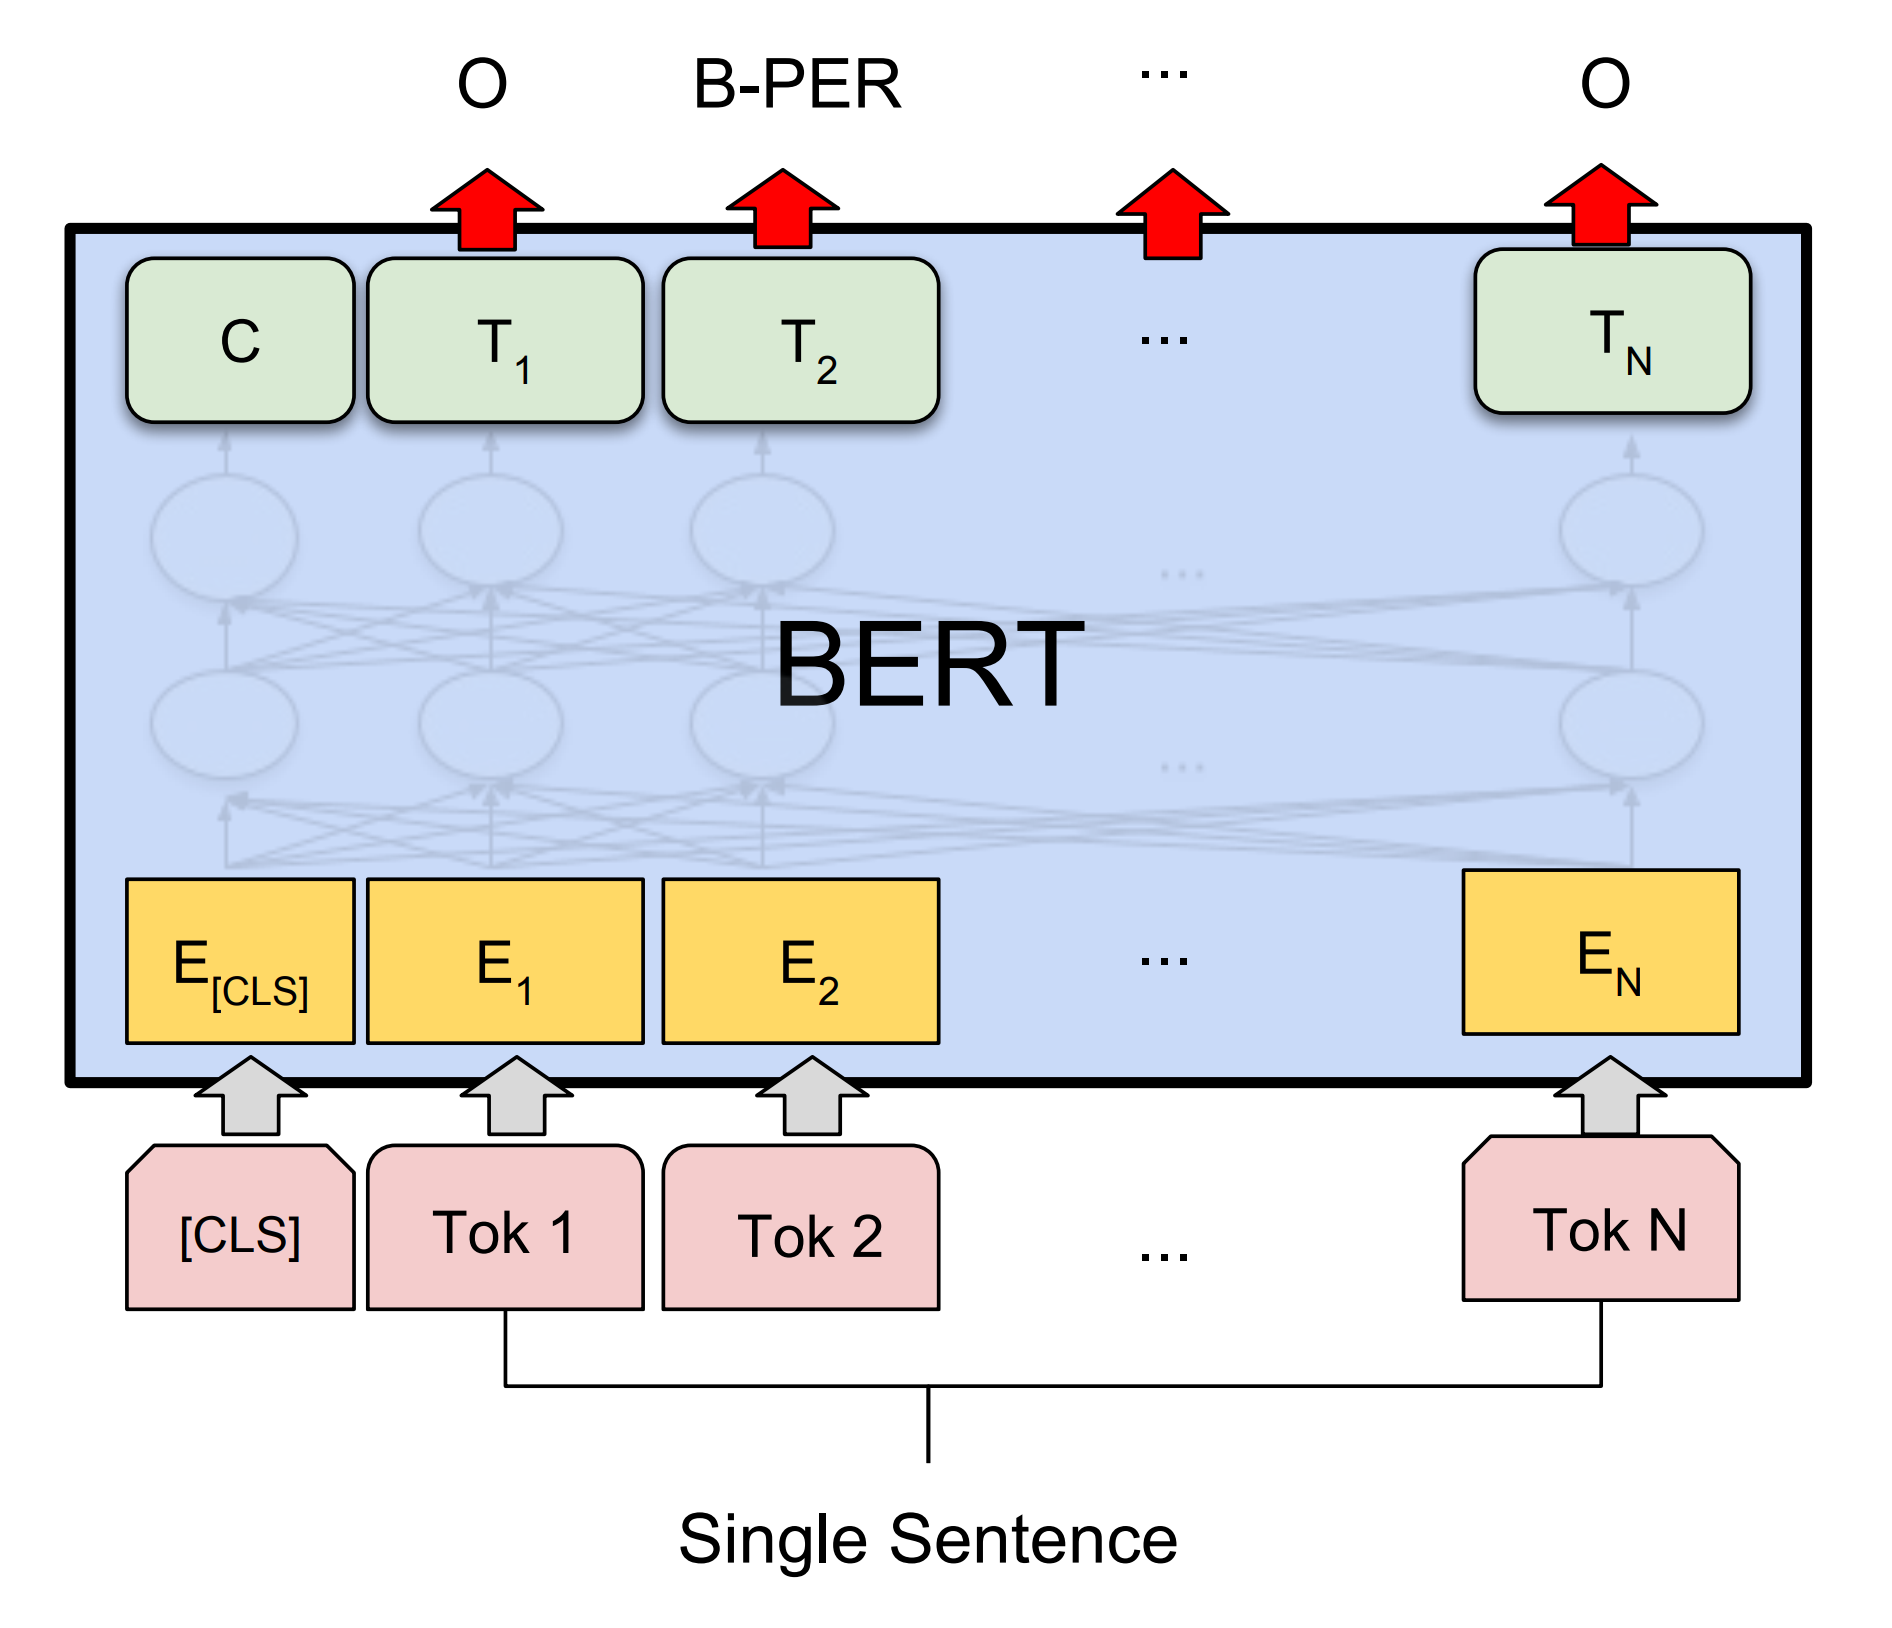

## Install and import libraries

In [ ]:
!pip install transformers datasets evaluate seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch


from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import pipeline

## Dataset



[Datasets](https://github.com/huggingface/datasets) library allows to load  popular datasets for various ML tasks. We'll use dataset Wikiann containing Wikipedia texts for different lanuages labeled with named entities.

In [ ]:
ds = load_dataset("wikiann", "en")

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset is split into train, test and validation subsets. Data contains tokens, NER tags, language indicator and NER spans.   

In [ ]:
ds

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

To access single sample we should select subset and sample index.
Print some examples from the dataset.

In [ ]:
print(ds['train'][-1])

print(ds['train'][5])

ds['train'][3]

{'tokens': ['List', 'of', 'regional', 'mammals', 'lists'], 'ner_tags': [3, 4, 4, 4, 4], 'langs': ['en', 'en', 'en', 'en', 'en'], 'spans': ['ORG: List of regional mammals lists']}
{'tokens': ['St.', 'Mary', "'s", 'Catholic', 'Church', '(', 'Sandusky', ',', 'Ohio', ')'], 'ner_tags': [3, 4, 4, 4, 4, 4, 4, 4, 4, 4], 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'], 'spans': ["ORG: St. Mary 's Catholic Church ( Sandusky , Ohio )"]}


{'tokens': ['Atlantic', 'City', ',', 'New', 'Jersey'],
 'ner_tags': [5, 6, 6, 6, 6],
 'langs': ['en', 'en', 'en', 'en', 'en'],
 'spans': ['LOC: Atlantic City , New Jersey']}

Field *tokens* contains input sentences split into words. Field *ner_tags* contains ids of NER markup tags in BIO format, first token of each entitiy is marked with B-prefix, inside tokens are marked with I-prefix, tokens that do not belong to any of named entities are labeled with O tag.  

Which entities are presented in the dataset?
Let's have a look at the names of all NER tags the dataset include.

In [ ]:
ner_feature = ds["train"].features["ner_tags"]
label_names = ner_feature.feature.names
print(label_names)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']


Create dictionaries to map tag ids (stored in the field ner_tags) to the names of the tags.

In [ ]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

How many examples does the dataset contain for each of the entity types?

In [ ]:
n_tags = {label_names[i]:0 for i in range(7)}

for subset in ds:
    for lst in ds[subset]['ner_tags']:
        for ele in lst:
            n_tags[id2label[ele]] +=1

n_tags

{'O': 163071,
 'B-PER': 18355,
 'I-PER': 29698,
 'B-ORG': 18844,
 'I-ORG': 46471,
 'B-LOC': 18836,
 'I-LOC': 25981}

## Preprocessing

Transformer-based models use Byte-Pair Encoding (BPE) tokenization that splits texts into tokens (words or subwords) according to their occurence in training corpus. So to apply the model we need to preprocess input sentences using tokenizer built during the training of the model.

In this exercise we will use [NER BERT model](https://huggingface.co/dslim/bert-base-NER) trained on CoNLL-2003 dataset. The model was trained for NER task with entity types contained in our dataset so we can use it to predict names entities for texts in our dataset.

In [ ]:
model_name = 'dslim/bert-base-NER'

We will initialize tokenizer using AutoTokenizer.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

Print some examples of tokenized texts from the dataset we are working with (Wikiann).

In [ ]:
indx = -2
inputs = tokenizer(ds["train"][indx]["tokens"], is_split_into_words=True)
print(ds["train"][indx]["tokens"])
inputs.tokens()

['16', '(', 'David', 'Nugent', ')']


['[CLS]', '16', '(', 'David', 'N', '##ugen', '##t', ')', '[SEP]']

Tokenizer output contains *input_ids* -- ids of tokens in model's vocabulary and *attention_mask* -- list of numbers 1 or 0 where 1 corresponds to tokens from input and 0 corresponds to padding special tokens [*PAD*].

As we can see new tokens do not match original tokenization of the dataset (in the dataset sentences were split into words) which means that we need to align NER labels from the dataset with BERT tokenized sentences.
There are different way for creating NER markup with subword tokenization, here we will the following strategy:
* Assign entitity tag only for the starting subtoken of the word
* Tag all inner subtokens with special label -100 because this index is ignored in loss function calculation.
* Mark special tokens ([CLS], [SEP], [PAD], [UNK]) with -100 label.


For example,

    Initial markup: Johnson(B-Person)

    Markup after tokenization: [CLS](-100) - John(B-Person) - ##son(-100)


Create a function that assigns entity label to the first subtoken within this entity and label -100 for all the rest subtokens of the entity and special tokens.

Tokenize dataset texts and create new labels using this function.  

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)

        else:
            # Same word as previous token
            new_labels.append(-100)

    return new_labels

inputs = tokenizer(ds["train"][0]["tokens"], is_split_into_words=True)
labels = ds["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print('Labels:', labels)
print('Aligned Labels:', align_labels_with_tokens(labels, word_ids))

Labels: [3, 4, 0, 3, 4, 4, 0, 0, 0, 0, 0]
Aligned Labels: [-100, 3, -100, -100, -100, 4, 0, 3, -100, 4, 4, 0, 0, 0, -100, 0, 0, -100]


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = ds.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=ds["train"].column_names,
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Now let's load pretrained model for token classification to see how it works on our dataset.

In [ ]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(model_name)

Check model's performance on several examples from the dataset:
* Tokenize input text
* Run model using input_ids and attention_mask from tokenized input
* Get predicted NER labels for model's output using id2label from the config of the model.

Get the predictions for the sample of 100 examples from the test subset.

In [ ]:
import pandas as pd

model.to('cuda:0')

for i, sample in enumerate(tokenized_datasets['test']):
    if i >= 100:
        break

    input_ids = torch.tensor(sample['input_ids']).view(1,-1).to('cuda:0')
    attention_mask = torch.tensor(sample['attention_mask']).view(1,-1).to('cuda:0')
    labels = torch.tensor(sample['labels']).view(1,-1).squeeze()
    output = model(input_ids = input_ids, attention_mask = attention_mask)

    int_preds = output.logits.argmax(axis=2).squeeze()
    model_id2tag = model.config.id2label
    preds = [model_id2tag[id.item()] for id in int_preds]

    tokens = tokenizer.convert_ids_to_tokens(sample["input_ids"])

    min_length = min(len(tokens), len(preds))
    tokens = tokens[:min_length]
    preds = preds[:min_length]

    df = pd.DataFrame({'tokens': tokens, 'predictions': preds})
    print(f"Iteration #{i}")
    print(df)
    print("\n")

Iteration #0
         tokens predictions
0         [CLS]           O
1       Shortly           O
2     afterward           O
3             ,           O
4            an           O
5   encouraging           O
6      response           O
7    influenced           O
8           him           O
9            to           O
10           go           O
11           to           O
12        India       B-LOC
13            ;           O
14           he           O
15      arrived           O
16           at           O
17           Ad       B-LOC
18        ##yar       I-LOC
19           in           O
20         1884           O
21            .           O
22        [SEP]           O


Iteration #1
       tokens predictions
0       [CLS]           O
1           :           O
2          Ka       B-PER
3        ##ny       B-PER
4         ##e       I-PER
5        West       I-PER
6   featuring           O
7       Jamie       B-PER
8         Fox       I-PER
9         ##x       I-PER
10          — 

Analyze the model's output, which entities were predicted incorrectly, can you see some patterns?
Note that the dataset is labeled for three types of entites (PER, LOC, ORG) while the model also predicts extra type (MISC).

Test the model on your own examples and describe the result.

> Model is doing pretty well on the test data, aside from some "I-" named entities being categorzed as a continuation of previous "B-" named entities, for some reason.

In [ ]:
examples = ['I am Inigo Montoya you killed my father prepare to die',
            'Houston, I have a problem',
            "Clark Kent, a Metropolis resident, is the leader of the Justice League",
            "You know what strong? Static and Demigod with Anna Zack",]
for sample in examples:

    tokens = tokenizer.tokenize(sample)
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    input_ids = torch.tensor(tokenizer.convert_tokens_to_ids(tokens)).to('cuda:0').view(1,-1)
    attention_mask = torch.ones_like(input_ids).to('cuda:0').view(1,-1)

    output = model(input_ids=input_ids, attention_mask=attention_mask)
    int_preds = output.logits.argmax(axis=2).squeeze()

    model_id2tag = model.config.id2label
    preds = [model_id2tag[id.item()] for id in int_preds]

    df = pd.DataFrame({'tokens': tokens, 'predictions': preds})
    print(f"Iteration #{i}")
    print(df)
    print("\n")

Iteration #100
     tokens predictions
0     [CLS]           O
1         I           O
2        am           O
3        In       B-PER
4     ##igo       B-PER
5      Mont       I-PER
6     ##oya       I-PER
7       you           O
8    killed           O
9        my           O
10   father           O
11  prepare           O
12       to           O
13      die           O
14    [SEP]           O


Iteration #100
    tokens predictions
0    [CLS]           O
1  Houston       B-LOC
2        ,           O
3        I           O
4     have           O
5        a           O
6  problem           O
7    [SEP]           O


Iteration #100
        tokens predictions
0        [CLS]           O
1        Clark       B-PER
2         Kent       I-PER
3            ,           O
4            a           O
5   Metropolis       B-LOC
6     resident           O
7            ,           O
8           is           O
9          the           O
10      leader           O
11          of           O
12       

> On our own examples, BERT is working perfectly besides failing to recognize Static as a person, despite having the aid of capitalization (Allowing it to add it in with the MISC crowd at the very least).

## Evaluation

The model was trained on CONLL-2003 dataset. We will evaluate model's performance on the test subset of this dataset.

Write code to evaluate the model:
* Load CONLL-2003 dataset
* Tokenize input texts and align NER tags markup
* Run the model to get predictions for test set
* Compute metrics using [seqeval](https://huggingface.co/spaces/evaluate-metric/seqeval) module of evaluate library (for evaluation we should ignore all non-starting subtokens within a word and special tokens).


In [ ]:
seqeval = evaluate.load("seqeval")
ds_con = load_dataset("conll2003")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ds_con_tokenized = ds_con.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=ds_con["test"].column_names,
)
ds_con_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'], device='cuda')

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

In [ ]:
dataset_id2tag = {i: tag for i,tag in enumerate(ds_con["test"].features["ner_tags"].feature.names)}
dataset_tag2id = {tag: i for i, tag in dataset_id2tag.items()}

model_id2tag = model.config.id2label
model_tag2id = {tag: i for i, tag in model_id2tag.items()}

In [ ]:
dataset_eval_ids = torch.tensor([i for i, tag in dataset_id2tag.items() if tag[0] == 'B']).to('cuda:0')
dataset_eval_ids

tensor([1, 3, 5, 7], device='cuda:0')

In [ ]:
def prepare_for_eval(examples):
    all_labels = examples["labels"]
    new_labels = []
    all_masks = []
    for labels in all_labels:

        mask = torch.isin(labels, dataset_eval_ids)
        eval_ids = labels[mask]

        eval_ids = [model_tag2id[dataset_id2tag[id.item()]] for id in eval_ids]

        new_labels.append(eval_ids)
        all_masks.append(mask)

    examples["labels"] = new_labels
    examples['eval_mask'] = all_masks
    return examples

ds_con_eval = ds_con_tokenized.map(
    prepare_for_eval,
    batched=True,
    remove_columns=ds_con_tokenized["test"].column_names,
)


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

In [ ]:
model.to('cuda:0')

predictions = []
references = []

for sample in ds_con_eval['test']:
    ids = sample['input_ids'].view(1,-1)
    attention_mask = sample['attention_mask'].view(1,-1)

    logits = model(input_ids = ids, attention_mask = attention_mask).logits
    pred = logits.argmax(axis=2).squeeze()

    eval_mask = sample['eval_mask']

    labels = sample['labels']
    labels = [model_id2tag[l.item()] for l in labels]

    clean_pred = pred[eval_mask]
    clean_pred = [model_id2tag[cp.item()] for cp in clean_pred]

    references.append(labels)
    predictions.append(clean_pred)


In [ ]:
seqeval.compute(predictions=predictions, references=references)

{'LOC': {'precision': 0.9482023156611822,
  'recall': 0.9328537170263789,
  'f1': 0.9404653974010274,
  'number': 1668},
 'MISC': {'precision': 0.8942598187311178,
  'recall': 0.8433048433048433,
  'f1': 0.8680351906158358,
  'number': 702},
 'ORG': {'precision': 0.9277912621359223,
  'recall': 0.9205298013245033,
  'f1': 0.9241462677546087,
  'number': 1661},
 'PER': {'precision': 0.9785759294265911,
  'recall': 0.9604205318491033,
  'f1': 0.9694132334581773,
  'number': 1617},
 'overall_precision': 0.9443842542434092,
 'overall_recall': 0.9259915014164306,
 'overall_f1': 0.9350974432326123,
 'overall_accuracy': 0.9279390934844193}

## Bonus: Fine-tuning
If you want to dive deeper in NER task, try to fine-tune base BERT model on Wikiann dataset following the tutorial.